This notebook provides an introduction for using a Variational Information Pursuit (V-IP) model pre-trained on the Mutagenicity dataset, to produce interpretable predictions for a given molecule.

In [1]:
import torch
import torch.nn.functional as F
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd

from arch.mutagenicity import QuerierMutagenicity, ClassifierMutagenicity
from train_mutagenicity import evaluate
from mutagenicity_utils import mol_to_query_answers, create_posterior_prob_heatmap
from dataset import get_frag_query_map
import ops

Load pre-trained V-IP model and set the size of the queryset that was used for training the model.

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('DEVICE:', device)

# Load the pre-trained model
model_path = './saved/3pd4ypqq/ckpt/epoch99.ckpt'
model = torch.load(model_path, weights_only=True, map_location=device)

# Set the size of the queryset used for training the model
QUERYSET_SIZE = 407

# Initialize the classifier and querier with the loaded model weights
classifier = ClassifierMutagenicity(queryset_size=QUERYSET_SIZE).to(device)
querier = QuerierMutagenicity(queryset_size=QUERYSET_SIZE, tau=1.0).to(device)

classifier.load_state_dict(model['classifier'])
querier.load_state_dict(model['querier'])

DEVICE: cuda


<All keys matched successfully>

Define an RDKit molecule. An example molecule is provided using SMARTS. Make sure to sanitize the molecule using `rdkit.Chem.SanitizeMol()` and appropriate flags, since the the molecule will be passed to `rdkit.Chem.Fragments` module functions.

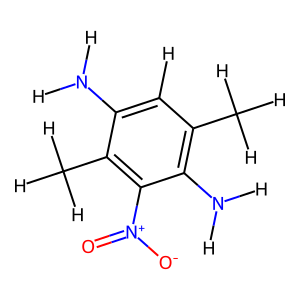

In [3]:
# Define RDKit molecule
smarts = '[#6]1(=[#6](-[#6](=[#6](-[#6](=[#6]-1-[#7](-[H])-[H])-[#6](-[H])(-[H])-[H])-[H])-[#7](-[H])-[H])-[#6](-[H])(-[H])-[H])-[#7+](=[#8])-[#8-]'
mol = Chem.MolFromSmarts(smarts)

# Sanitize the molecule
Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ 
                                  Chem.SanitizeFlags.SANITIZE_SETAROMATICITY ^ 
                                  Chem.SanitizeFlags.SANITIZE_KEKULIZE)

# Visualize the molecule for sanity check
img = Draw.MolToImage(mol)
img

Load the queryset that was used for training the V-IP model. For the molecule previously defined, compute answers to all queries in the given queryset. 

NOTE: Any manually defined queryset must have the same format as the querysets generated by `generate_queryset.py`   

In [4]:
QUERY_SET_PATH = './data/rdkit_queryset.csv'
queryset = pd.read_csv(QUERY_SET_PATH)

frag_query_map = get_frag_query_map(queryset)
qry_ans = mol_to_query_answers(mol, frag_query_map, device)

Evaluate the model on the defined molecule.

In [5]:
params = {
    'test_features': qry_ans,
    'querier': querier,
    'classifier': classifier,
    'n_queries': QUERYSET_SIZE,
    'max_queries_test': 20,
}
logits, queries = evaluate(**params)

The model will ask queries sequentially until a class prediction is made that surpasses a set confidence threshold (a probability from 0 to 1). Define the variable `CONFIDENCE_THRESHOLD` and run the cell to visualize the sequence of queries asked and the final class prediction. Refer to *Figure 5b* in the paper for a method of testing different confidence thresholds on a test dataset.  

A query $q_i$ will have the form `q<i>: <functional_group_name>=<num_of_occurences>?`.

For example, the query `q2: benzene=2?` is read as **Query #2:** *Are there 2 benzene functional groups present in the molecule?*"

In the visualization, a query is coloured <span style="color:green">GREEN</span> or <span style="color:red">RED</span> to represent a *YES* or *NO* answer to the query respectively.

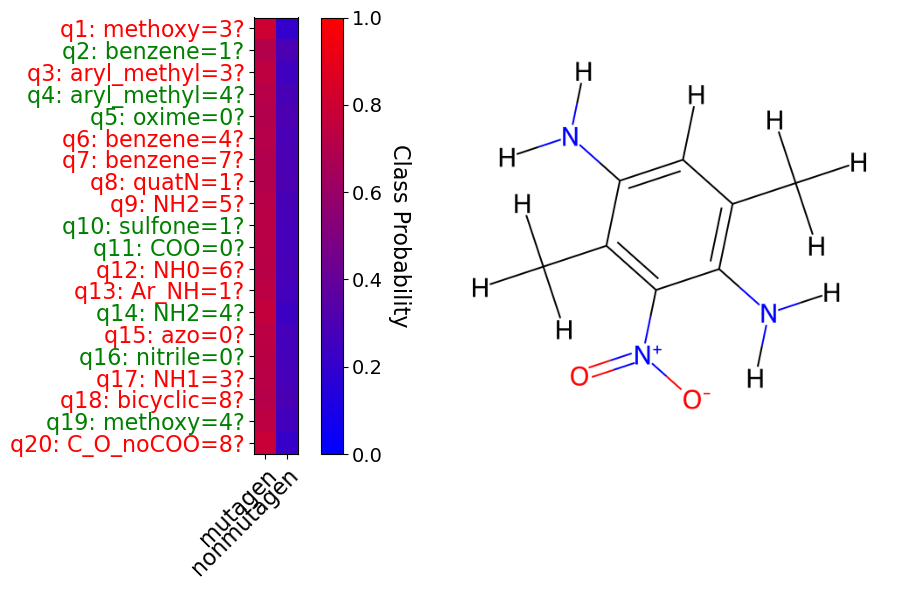

In [6]:
CONFIDENCE_THRESHOLD = 0.85

num_queries_needed_ip = ops.compute_queries_needed(logits, CONFIDENCE_THRESHOLD)
probs = F.softmax(logits, dim=2)
probs_ip = probs[0, 0:num_queries_needed_ip, :]
queries_ip = queries[0, 0:num_queries_needed_ip, :]


# Visulaization
params = {
    'mol': mol,
    'probs': probs_ip,
    'queries': queries_ip,
    'answers': qry_ans[0],
    'threshold': CONFIDENCE_THRESHOLD,
}
fig, ax = create_posterior_prob_heatmap(**params)